# Genetic programming


In [1]:
import numpy as np
from deap import base, creator, gp, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import operator


In [2]:
# Inicia o individuo e a função de fitness
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)


In [3]:
# Adiciona os operadores permitidos
def power(x, y):
    return np.power(np.abs(x), np.abs(y))


pset = gp.PrimitiveSet(name="MAIN", arity=1)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(power, arity=2)
pset.addPrimitive(np.negative, arity=1)
pset.addPrimitive(np.cos, arity=1)
pset.addPrimitive(np.sin, arity=1)
pset.addEphemeralConstant("Constant", lambda: np.round(np.random.uniform(-10, 10), 2))
pset.renameArguments(ARG0="x")


In [4]:
# Instância a população
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [5]:
# Retorna o erro
def evaluateRegression(individual, points: np.array, pset, fun):
    func = gp.compile(expr=individual, pset=pset)
    sqerrors = (func(points) - fun(points)) ** 2
    n = len(points)
    return (np.sqrt(np.sum(sqerrors) / n),)


In [6]:
def fun_alvo(x):
    return x**2 + 4 + np.sin(x**2) - np.cos(x)


In [7]:
points = np.arange(-10, 10, 0.01)

toolbox.register("evaluate", evaluateRegression, points=points, pset=pset, fun=fun_alvo)
toolbox.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=5)

toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.decorate(
    "mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10)
)
toolbox.decorate(
    "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10)
)


/tmp/ipykernel_7113/3083526304.py:3: RuntimeWarning: overflow encountered in power
  return np.power(np.abs(x), np.abs(y))
/tmp/ipykernel_7113/306959457.py:4: RuntimeWarning: overflow encountered in square
  sqerrors = (func(points) - fun(points)) ** 2


add(multiply(add(-1.51, -3.19), cos(-9.0)), multiply(subtract(x, power(sin(power(power(sin(-1.55), power(add(add(7.58, -1.55), negative(x)), multiply(subtract(4.91, 2.33), subtract(-3.19, x)))), subtract(2.33, cos(x)))), subtract(-9.74, cos(power(add(add(7.58, -1.99), x), x))))), x))
(0.8683849048916545,)


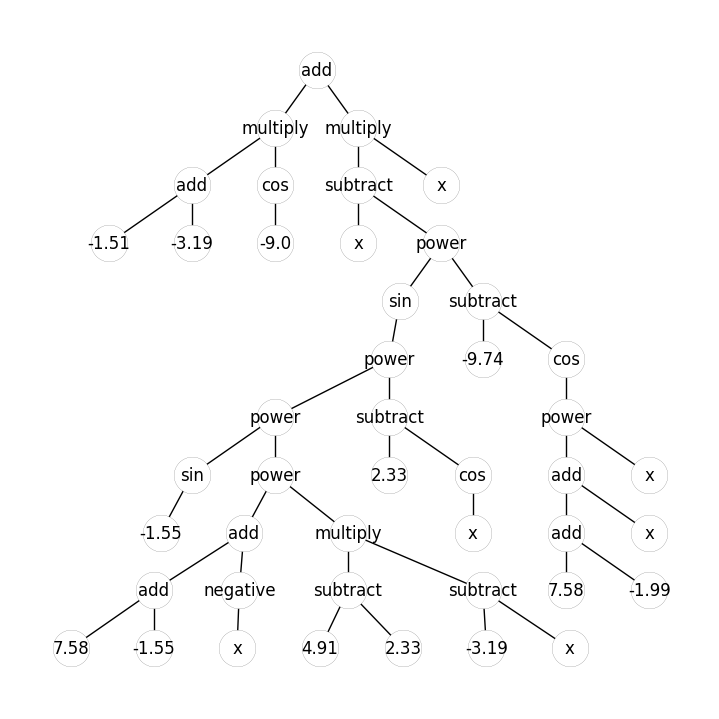

In [26]:
pop = toolbox.population(n=300)
algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=False)
bests = tools.selBest(pop, k=1)
best = bests[0]
print(best)
print(best.fitness)
best_fun = gp.compile(best, pset)

nodes, edges, labels = gp.graph(best)
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
pos = graphviz_layout(graph, prog="dot")

options = {
    "font_size": 30,
    "node_size": 700,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 0.1,
    "width": 1,
}

plt.figure(figsize=(7, 7))
nx.draw(graph, pos, **options)

nx.draw_networkx_labels(graph, pos, labels)
plt.show()


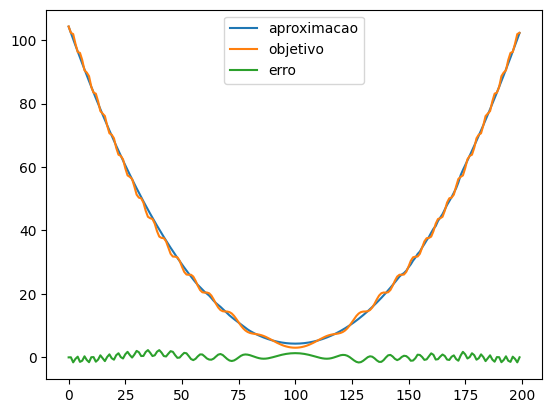

In [28]:
points_test = points = np.arange(-10, 10, 0.1)
aproximacao = best_fun(points_test)
objetivo = fun_alvo(points_test)
erro = aproximacao - objetivo

plt.figure()
sns.lineplot(data=aproximacao, label="aproximacao")
sns.lineplot(data=objetivo, label="objetivo")
sns.lineplot(data=erro, label="erro")
plt.show()
plt.close()


In [63]:
from copy import deepcopy as dc
bkp_best = dc(best)
print(bkp_best)

add(multiply(add(-1.51, -3.19), cos(-9.0)), multiply(subtract(x, power(sin(power(power(sin(-1.55), power(add(add(7.58, -1.55), negative(x)), multiply(subtract(4.91, 2.33), subtract(-3.19, x)))), subtract(2.33, cos(x)))), subtract(-9.74, cos(power(add(add(7.58, -1.99), x), x))))), x))


## Simplificando a árvore

In [12]:
[(type(b), b.name, b.arity) for i, b in enumerate(best)]


[(deap.gp.Primitive, 'subtract', 2),
 (deap.gp.Primitive, 'add', 2),
 (deap.gp.Constant, '-1.52', 0),
 (deap.gp.Primitive, 'add', 2),
 (deap.gp.Primitive, 'sin', 1),
 (deap.gp.Primitive, 'sin', 1),
 (deap.gp.Primitive, 'multiply', 2),
 (deap.gp.Terminal, 'ARG0', 0),
 (deap.gp.Terminal, 'ARG0', 0),
 (deap.gp.Primitive, 'multiply', 2),
 (deap.gp.Primitive, 'negative', 1),
 (deap.gp.Terminal, 'ARG0', 0),
 (deap.gp.Primitive, 'negative', 1),
 (deap.gp.Terminal, 'ARG0', 0),
 (deap.gp.Constant, '-5.6', 0)]

In [29]:
def constantify(value, pset):
    code = f"lambda: {value}"
    new_value = np.round(eval(code, pset.context)(),2)

    new_constant = gp.Constant()
    new_constant.name = str(new_value)
    new_constant.value = new_value
    return new_constant


In [207]:
def all_constants(b, bs):
    if all(map(lambda x: isinstance(x, gp.Constant), bs)):
        code = b.format(*map(lambda x: x.value, bs))
        new_c = constantify(code, pset)
        # print(f"{code} = {new_c.value}")
        return new_c


def all_terminal(bs):
    return all(map(lambda x: isinstance(x, gp.Terminal), bs))


def all_constant_or_terminal(bs):
    return all(
        map(lambda x: isinstance(x, gp.Constant) or isinstance(x, gp.Terminal), bs)
    )


In [125]:
def add_negative2subtract(b, bs):
    if b.name != "add":
        return

    return bs[1].name == "negative" and all_constant_or_terminal((bs[0],))

In [62]:
nova_arvore = creator.Individual((best[0],))

In [199]:
best = dc(bkp_best)

In [212]:
def simplify_tree():
    for i, b in enumerate(best):
        match b:
            case gp.Primitive():
                bs = [best[i + j] for j in range(1, b.arity + 1)]

                if new_c := all_constants(b, bs):
                    best.pop(i)
                    best[i] = new_c

                    for _ in range(1, b.arity):
                        best.pop(i + 1)
                    return simplify_tree()
                
                if add_negative2subtract(b, bs):
                    best[i] = pset.mapping['subtract']
                    p = len(best[best.searchSubtree(i+1)])
                    best.pop(i+p+1)
                    return simplify_tree()

best = dc(bkp_best)
simplify_tree()



add 6.03 negative
subtract 6.03 negative
11 1 13



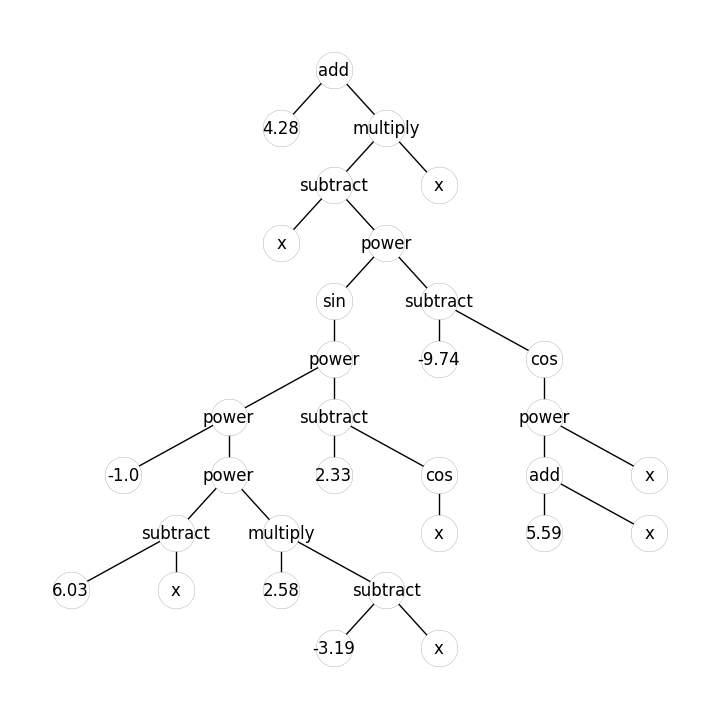

In [213]:
nodes, edges, labels = gp.graph(best)
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
pos = graphviz_layout(graph, prog="dot")

options = {
    "font_size": 30,
    "node_size": 700,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 0.1,
    "width": 1,
}

plt.figure(figsize=(7, 7))
nx.draw(graph, pos, **options)

nx.draw_networkx_labels(graph, pos, labels)
plt.show()